First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". 


There are 3 datasets, in this work they will be combined together at species and genus level.

These 3 datasets comes from :
1) 96 sampels: Lloyd-Price J, Arze C, Ananthakrishnan AN, et al. Multi-omics of the gut microbial ecosystem in inflammatory bowel diseases. Nature 2019
2) 836 samples: Flores GE, Caporaso JG, Henley JB, et al. Temporal variability is a personalized feature of the human microbiome. Genome Biol 2014
3) 637 samples: Halfvarson J, Brislawn CJ, Lamendella R, et al. Dynamics of the human gut microbiome in inflammatory bowel disease. Nat Microbiol 2017

In [1]:
import sys
sys.path.append('../../../Code')
import loadData 
import RunML
import FS
import metric



2025-03-10 01:21:13.866266: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import pickle

In [3]:
total_features_species = np.load('../data/total_features_species.npy')
total_features_genus = np.load('../data/total_features_genus.npy')
total_label= np.load('../data/total_label.npy')

In [4]:
print(total_features_species.shape)
print(total_features_genus.shape)

(1569, 283)
(1569, 220)


In [5]:
print(total_features_species)

[[0.00000000e+00 2.73776273e+01 2.27323259e+00 ... 0.00000000e+00
  9.88361996e-02 6.62202537e+00]
 [0.00000000e+00 9.49663099e+00 5.10571559e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.47664336e+02 3.94624672e-01 ... 7.89249345e-02
  0.00000000e+00 1.10494908e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [6]:
le = LabelEncoder()
y= le.fit_transform(total_label)

In [7]:
pd.DataFrame(y).value_counts()


0    867
1    702
Name: count, dtype: int64

### 2. Calculating H score for each OTU

In [8]:
taxlabels = ['Species','Genus']
feature_df_list = [pd.DataFrame(total_features_species,
                                         columns = [f"column_{i+1}" for i in range(total_features_species.shape[1])]),
                   pd.DataFrame(total_features_genus,
                                         columns = [f"column_{i+1}" for i in range(total_features_genus.shape[1])])]

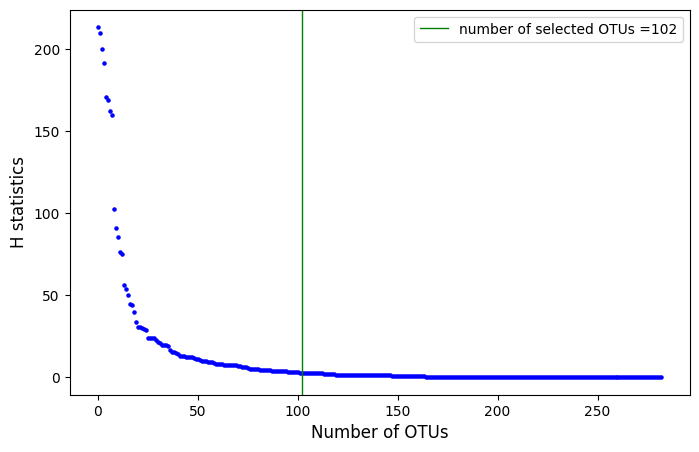

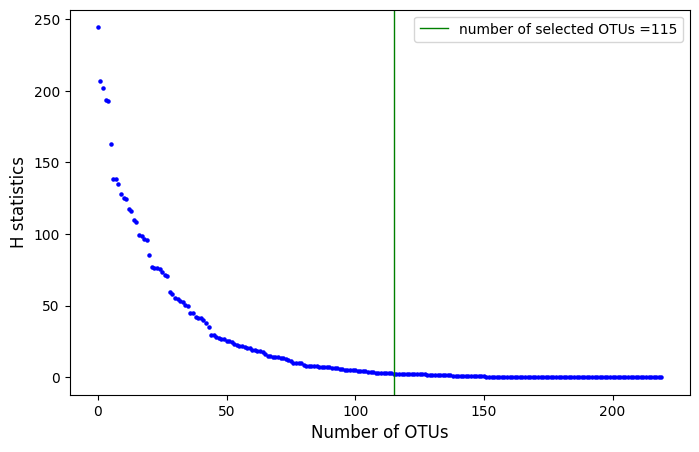

In [9]:
selectedresult_list = []
for feature_df in feature_df_list:
    selectedresult=FS.SelectMicro_fun(feature_df,y)
    selectedresult_list.append(selectedresult)

### Prepare other datasets

In [10]:
featurenames_full = [feature_df_list[0].columns,feature_df_list[1].columns]
selectedOTU_index_Lasso_list = []
selectedOTU_index_FS_lasso_list = []
selectedOTU_index_Lasso_FS_list = []

data_subset_list = []

for selectedresult in selectedresult_list:
    selectedOTU_index_FS = selectedresult['selected_indices']

    data = selectedresult['relative_abundance_data']
    X_FS = selectedresult['selected_data']

    X_lasso_ft,selectedOTU_index_Lasso  = RunML.LassoFS_CV(data,y)
    selectedOTU_index_Lasso_list.append(selectedOTU_index_Lasso)

    X_FS_lasso_ft,xlabel_FS_lasso_ft0  = RunML.LassoFS_CV(X_FS,y)
    selectedOTU_index_FS_lasso = selectedOTU_index_FS[xlabel_FS_lasso_ft0]
    selectedOTU_index_FS_lasso_list.append(selectedOTU_index_FS_lasso)
    
    selectedOTU_index_Lasso_FS = np.intersect1d(selectedOTU_index_Lasso, selectedOTU_index_FS)
    selectedOTU_index_Lasso_FS_list.append(selectedOTU_index_Lasso_FS)
    X_lasso_FS = data[:,selectedOTU_index_Lasso_FS]
    
    
    data_subset = {"AllFeatures":data,
               "SelectMicro": X_FS,
               "Lasso_finetune":X_lasso_ft,
               "FS_Lassofinetune":X_FS_lasso_ft,
               "Lassofinetune_FS":X_lasso_FS
              }
    data_subset_list.append(data_subset)

Best alpha: 0.005
Best alpha: 0.005
Best alpha: 0.005
Best alpha: 0.005


In [11]:
for data in data_subset_list:
    print(f'The shape of the original dataset is ',np.shape(data['AllFeatures']))
    print(f'The shape of the SelectMicro dataset is ',np.shape(data['SelectMicro']))
    print(f'The shape of the Lasso_finetune selected dataset is ',np.shape(data['Lasso_finetune']))
    print(f'The shape of the FS_Lasso_finetune selected dataset is ',np.shape(data['FS_Lassofinetune']))
    print(f'The shape of the Lasso_finetune_FS selected dataset is ',np.shape(data['Lassofinetune_FS']))

The shape of the original dataset is  (1569, 283)
The shape of the SelectMicro dataset is  (1569, 102)
The shape of the Lasso_finetune selected dataset is  (1569, 126)
The shape of the FS_Lasso_finetune selected dataset is  (1569, 84)
The shape of the Lasso_finetune_FS selected dataset is  (1569, 81)
The shape of the original dataset is  (1569, 220)
The shape of the SelectMicro dataset is  (1569, 115)
The shape of the Lasso_finetune selected dataset is  (1569, 109)
The shape of the FS_Lasso_finetune selected dataset is  (1569, 85)
The shape of the Lasso_finetune_FS selected dataset is  (1569, 83)


### Modeling

In [12]:
cls = ["RF","SVM", "CatBoost","NB","xgboost"]
for i , dataset  in enumerate(data_subset_list):
    print(f"Analysis for {taxlabels[i]}")
    dict_cm = RunML.runClassifier_FScompare(data_subsets= dataset,y= y,classifiers=cls)
    print(metric.metric_sum(dict_cm))

Analysis for Species
Classes: [0 1]
0.9282581068339277
0.931332759398188
0.9396962233169129
0.954987684729064
0.9094756399669695
0.8849669987291436
0.8761529947115976
0.8480295566502463
0.8871921182266009
0.8648431048720067
0.9230926905259704
0.9144426679785185
0.910632183908046
0.932840722495895
0.9186622625928985
0.8120362399048908
0.8614971508219571
0.834688013136289
0.824692118226601
0.8549132947976879
0.9074734554995285
0.9275611855860287
0.9167898193760262
0.936863711001642
0.9131296449215525
0.9166154224572624
0.9264338129791333
0.9228448275862069
0.9451559934318555
0.9124483897605284
0.8892305169515844
0.8754560734636986
0.8385467980295567
0.8792077175697866
0.8734723369116434
0.9178452834829663
0.9207559545771328
0.9147372742200328
0.930623973727422
0.9129232039636664
0.82833189849547
0.872258434796868
0.8526272577996716
0.8547824302134646
0.8575557390586293
0.9023490345590949
0.9228467183208297
0.9066091954022988
0.9315270935960591
0.9117671345995045
0.9176198089615873
0.9352

0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089
0.9119735755573907
0.8844340589513385
0.8945599147296357
0.8623563218390804
0.8826354679802956
0.8771676300578034
0.914237691140901
0.9293649817570615
0.891543513957307
0.9338259441707717
0.9108175061932287
0.7992046898700448
0.8698397081129832
0.7751847290640395
0.7847701149425288
0.7944673823286541
0.9056696593284959
0.9248554913294798
0.9013957307060756
0.9404351395730707
0.90532617671346
0.9192596236625261
0.9311892756118558
0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0

In [13]:
def GridSearchRF(X_df,y,SMOTE=False,k=5):

   
    df = X_df
    
    ft_list = X.columns

    X = df.to_numpy()

    # configure the cross-validation procedure
    # Set up 5-fold cross-validation
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=777)

    # performance reports
    accuracy_results = list()
    f1_results = list()
    precision_results = list()
    recall_results = list()

    # preparation for ROC curve
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(6, 6))

    enriched_all = pd.DataFrame(ft_list, columns = ['Taxa'])
    list_shap_values = list()
    list_test_sets = list()

    
    idx = 0
    for train_ix, test_ix in cv_outer.split(X):
        
    
        # split data
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]


        # configure the cross-validation procedure
        cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)

        # define the model
        clf = RandomForestClassifier(n_jobs=5, random_state=777)

        # define search space
        space = dict()
        space['n_estimators'] = [100, 200, 500, 750, 1000, 1500, 2000]
        space['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 11)]
        space['min_samples_leaf'] = [1, 2, 4]
        space['min_samples_split'] = [2, 5, 10]
        space['max_features'] = ['sqrt', 'log2']

        # define search
        search = GridSearchCV(clf, space, scoring='accuracy', n_jobs=-1, cv=cv_inner, refit=True)
        # execute search
        result = search.fit(X_train, y_train)

        # get the best performing model fit on the whole training set
        best_model = result.best_estimator_
        
        # evaluate model on the hold out dataset
        yhat = best_model.predict(X_test)
        # evaluate the model
        acc = accuracy_score(y_test, yhat)
        f1 = f1_score(y_test, yhat)
        prec = precision_score(y_test, yhat)
        rec = recall_score(y_test, yhat)

        # store the result
        accuracy_results.append(acc)
        f1_results.append(f1)
        precision_results.append(prec)
        recall_results.append(rec)

        # ROC curve
        best_model.fit(X_train, y_train)
        viz = RocCurveDisplay.from_estimator(
            best_model,
            X_test,
            y_test,
            name=f"Best model {idx+1}",
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)# interpolate TPR values at mean FPR points based on output
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)#AUC value

        # SHAP values
        explainer = shap.TreeExplainer(best_model)
        shap_obj = explainer(X_test)
        shap_values = explainer.shap_values(X_test)
        list_shap_values.append(shap_values)
        list_test_sets.append(test_ix)
        

        high_index = pd.DataFrame(shap_obj.data, columns=shap_obj.feature_names, index=X_test.index).idxmax()# the dataframe is the test data but the index is from the orginal data; idxmax returns the index for the maximum value in each column.
        shap_1 = pd.DataFrame(shap_values[1], columns=shap_obj.feature_names, index=X_test.index)
        
        enriched = list()
        for v, i in high_index.items():
            sv = shap_1[v].loc[i]
            if sv<0:
                sv = "Level 0"
            else:
                sv = "Level 1"
            enriched.append(
                {
                    'Taxa': v,
                    'enriched': sv
                }
            )
        enriched = pd.DataFrame(enriched)
        enriched.rename(columns={'enriched': 'enriched{}'.format(idx+1)}, inplace=True)
        enriched_all = enriched_all.merge(enriched, on='Taxa', how='outer')

        idx += 1

    # continue ROC
    ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve on {rank} rank",
    )
    ax.axis("square")
    ax.legend(loc="lower right")
    #plt.show()

    #combining results from all iterations
    test_set = list_test_sets[0]
    shap_values = np.array(list_shap_values[0])
    for i in range(1,len(list_test_sets)):
        test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
        shap_values = np.concatenate((shap_values,np.array(list_shap_values[i])),axis=1)

    #bringing back variable names    
    X_test = pd.DataFrame(X.iloc[test_set])
    X_test.columns = ft_list
    
    #creating explanation plot for the whole experiment
    #shap.summary_plot(shap_values[1], X_test)
    enriched_all.to_csv('../data/SHAP/SHAP_enriched_' + rank + '.csv', index=False)

    # SHAP feature importances
    mean_shap_feature_values = pd.DataFrame(shap_values[1], columns=ft_list).abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_feature_values.index.name = 'features'
    mean_shap_feature_values.name = 'mean_shap'
    mean_shap_feature_values = mean_shap_feature_values.reset_index()
    mean_shap_feature_values.to_csv('data/SHAP_feature_importance_' + rank + '.csv', index=False)

    # summarize the estimated performance of the model
    print('Accuracy: %.3f (%.3f), F1: %.3f (%.3f), Precision: %.3f (%.3f), Recall: %.3f (%.3f)' % (np.mean(accuracy_results), np.std(accuracy_results), np.mean(f1_results), np.std(f1_results), np.mean(precision_results), np.std(precision_results), np.mean(recall_results), np.std(recall_results)))

In [14]:

for i , datasubset  in enumerate(data_subset_list):#[['Species','Genus']]
   
    for index, (key, value) in enumerate(datasubset.items()):# 5 different feature selection method
        print(f"Run RF model for: rank:{taxlabels[i]}, feature selection method: {key}")
        dict_cm = RunML.runClassifier_FScompare(data_subsets= dataset,y= y,classifiers=cls)
        print(metric.metric_sum(dict_cm))

Run RF model for: rank:Species, feature selection method: AllFeatures
Classes: [0 1]
0.9248349936457181
0.941151149920059
0.9301724137931034
0.9508210180623974
0.9159165978530142
0.895297831345058
0.9016931086787193
0.8641625615763545
0.8825533661740559
0.886478117258464
0.9131718115852909
0.9221088017054073
0.9127257799671593
0.9369868637110016
0.908670520231214
0.7635592178083876
0.7980568195793876
0.7479474548440066
0.7289408866995074
0.7598265895953757
0.9057926454310663
0.9230926905259705
0.9185139573070608
0.9346880131362889
0.9134186622625929
0.9175788135940639
0.9351043332103474
0.9306239737274219
0.950923645320197
0.9079066886870355
0.8889845447464436
0.8978395441315131
0.8662561576354679
0.8760673234811165
0.883402146985962
0.9186651908334358
0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901

0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089
0.9119735755573907
0.8844340589513385
0.8945599147296357
0.8623563218390804
0.8826354679802956
0.8771676300578034
0.914237691140901
0.9293649817570615
0.891543513957307
0.9338259441707717
0.9108175061932287
0.7992046898700448
0.8698397081129832
0.7751847290640395
0.7847701149425288
0.7944673823286541
0.9056696593284959
0.9248554913294798
0.9013957307060756
0.9404351395730707
0.90532617671346
0.9192596236625261
0.9311892756118558
0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255

0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0.9362479474548441
0.9042113955408753
0.9153650637477965
0.9296314516459641
0.9164203612479475
0.9462233169129721
0.9055532617671347
0.8793916287459518
0.8906038617636207
0.8620279146141215
0.8745073891625615
0.8726672171758877
0.9034149141147051
0.9225187553806419
0.8914614121510672
0.933128078817734
0.9111478117258464
0.7878079776985201
0.8308121182306399
0.7622947454844007
0.7707922824302135
0.7743393889347647
0.9095232238757021
0.9274791948509818
0.9003284072249589
0.9362889983579639
0.90355078447564
                  RF_Accuracy   RF_AUC    RF_mcc     RF_F    SVM_Accuracy  \
AllFeatures       

0.9095232238757021
0.9274791948509818
0.9003284072249589
0.9362889983579639
0.90355078447564
                  RF_Accuracy   RF_AUC    RF_mcc     RF_F    SVM_Accuracy  \
AllFeatures        0.865518    0.932579  0.735454  0.858295    0.799249     
SelectMicro        0.854051    0.928427  0.711464  0.845316    0.802428     
Lasso_finetune     0.854051    0.927640  0.713555  0.846757    0.794139     
FS_Lassofinetune   0.843208    0.925238  0.691481  0.835286    0.789036     
Lassofinetune_FS   0.850854    0.922639  0.707094  0.843535    0.789673     

                   SVM_AUC   SVM_mcc    SVM_F   CatBoost_Accuracy  \
AllFeatures       0.886037  0.602091  0.787254      0.850237        
SelectMicro       0.882510  0.609123  0.791247      0.849586        
Lasso_finetune    0.880231  0.593922  0.783777      0.838764        
FS_Lassofinetune  0.875856  0.584850  0.780034      0.836837        
Lassofinetune_FS  0.875840  0.585998  0.780559      0.832386        

                  CatBoost_AU

0.941151149920059
0.9301724137931034
0.9508210180623974
0.9159165978530142
0.895297831345058
0.9016931086787193
0.8641625615763545
0.8825533661740559
0.886478117258464
0.9131718115852909
0.9221088017054073
0.9127257799671593
0.9369868637110016
0.908670520231214
0.7635592178083876
0.7980568195793876
0.7479474548440066
0.7289408866995074
0.7598265895953757
0.9057926454310663
0.9230926905259705
0.9185139573070608
0.9346880131362889
0.9134186622625929
0.9175788135940639
0.9351043332103474
0.9306239737274219
0.950923645320197
0.9079066886870355
0.8889845447464436
0.8978395441315131
0.8662561576354679
0.8760673234811165
0.883402146985962
0.9186651908334358
0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089

0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089
0.9119735755573907
0.8844340589513385
0.8945599147296357
0.8623563218390804
0.8826354679802956
0.8771676300578034
0.914237691140901
0.9293649817570615
0.891543513957307
0.9338259441707717
0.9108175061932287
0.7992046898700448
0.8698397081129832
0.7751847290640395
0.7847701149425288
0.7944673823286541
0.9056696593284959
0.9248554913294798
0.9013957307060756
0.9404351395730707
0.90532617671346
0.9192596236625261
0.9311892756118558
0.9224548440065682
0.9492200328407225
0.9040668868703551
0.8791046611732874
0.8906858524986676
0.8620279146141215
0.8747126436781609
0.8727497935590421
0.907514450867052
0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0

0.9311687779280942
0.894376026272578
0.9357963875205255
0.9058216350123864
0.787889968433567
0.8245603246833108
0.7623563218390804
0.7688423645320197
0.7700454170107349
0.9079244045422867
0.9318247038084696
0.897495894909688
0.9362479474548441
0.9042113955408753
0.9153650637477965
0.9296314516459641
0.9164203612479475
0.9462233169129721
0.9055532617671347
0.8793916287459518
0.8906038617636207
0.8620279146141215
0.8745073891625615
0.8726672171758877
0.9034149141147051
0.9225187553806419
0.8914614121510672
0.933128078817734
0.9111478117258464
0.7878079776985201
0.8308121182306399
0.7622947454844007
0.7707922824302135
0.7743393889347647
0.9095232238757021
0.9274791948509818
0.9003284072249589
0.9362889983579639
0.90355078447564
                  RF_Accuracy   RF_AUC    RF_mcc     RF_F    SVM_Accuracy  \
AllFeatures        0.865518    0.932579  0.735454  0.858295    0.799249     
SelectMicro        0.854051    0.928427  0.711464  0.845316    0.802428     
Lasso_finetune     0.854051    0.9

0.941151149920059
0.9301724137931034
0.9508210180623974
0.9159165978530142
0.895297831345058
0.9016931086787193
0.8641625615763545
0.8825533661740559
0.886478117258464
0.9131718115852909
0.9221088017054073
0.9127257799671593
0.9369868637110016
0.908670520231214
0.7635592178083876
0.7980568195793876
0.7479474548440066
0.7289408866995074
0.7598265895953757
0.9057926454310663
0.9230926905259705
0.9185139573070608
0.9346880131362889
0.9134186622625929
0.9175788135940639
0.9351043332103474
0.9306239737274219
0.950923645320197
0.9079066886870355
0.8889845447464436
0.8978395441315131
0.8662561576354679
0.8760673234811165
0.883402146985962
0.9186651908334358
0.9239945886114869
0.9077996715927751
0.9355911330049261
0.9113955408753096
0.7822736030828517
0.7974418890665353
0.7525862068965516
0.7484400656814449
0.7669281585466556
0.9117369737219693
0.9264953060304185
0.9071428571428571
0.9339901477832513
0.9137902559867878
0.9185832000983888
0.9350018447915387
0.9254105090311987
0.9472290640394089

# summary of results in latex
# in genus

In [15]:
def plot_dim_reduction(X, y, method='PCA', perplexity=30, n_components=2,datalabel=None):
    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply dimensionality reduction
    if method.upper() == 'PCA':
        reducer = PCA(n_components=n_components)
        X_reduced = reducer.fit_transform(X_scaled)
        title = f'PCA Plot {datalabel}'
    elif method.upper() == 'TSNE':
        reducer = TSNE(n_components=n_components, perplexity=perplexity, random_state=42)
        X_reduced = reducer.fit_transform(X_scaled)
        title = f't-SNE Plot {datalabel}'
    else:
        raise ValueError("Method should be either 'PCA' or 'tSNE'")

    # Create DataFrame for plotting
    df_plot = pd.DataFrame(X_reduced, columns=[f'Component {i+1}' for i in range(n_components)])
    df_plot['Label'] = y

    # Plot
    plt.figure(figsize=(4, 3))
    for label in np.unique(y):
        subset = df_plot[df_plot['Label'] == label]
        plt.scatter(subset.iloc[:, 0], subset.iloc[:, 1], label=f'Class {label}', alpha=0.7)

    plt.xlabel(df_plot.columns[0])
    plt.ylabel(df_plot.columns[1])
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [16]:
# plot the family 
for datatype, subset in data_subset_list[0].items():   
    RunML.plot_dim_reduction(subset, y, method='PCA',datalabel=datatype)

NameError: name 'plt' is not defined

In [ ]:
# plot the genus 
for datatype, subset in data_subset_list[1].items():    
     RunML.plot_dim_reduction(subset, y, method='PCA',datalabel=datatype)

## compare the first 15 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# the   df with the largest H statistics features
entries=15
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]
df=pd.DataFrame(data=X_FS_15)


In [ ]:
# the column names of the featues
ASVs = cols_name
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

In [ ]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)

In [ ]:
selectedASV_lasso = [cols_name[i] for i in xlabel_lasso]
RunML.plotPresenseRatio(X_lasso,targetLabel,selectedASV_lasso,posLabel="IBD",posText="IBD",negText="nonIBD",entries=len(selectedASV_lasso))

In [ ]:
selectedASVs

In [ ]:
qitta_combine[['Diagnosis','X4414821']].value_counts()

In [ ]:
selectedASV_lasso